# Cluster Power Spectrum, $P(k)$ and Correlation Functions, $\xi(r)$

Display results

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
# !pip install nbodykit

In [6]:
from nbodykit.lab import *
from nbodykit import setup_logging, style

from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
plt.style.use(style.notebook)

In [7]:
#!/usr/bin/env python
import os, fitsio

import sys
import numpy as np
import matplotlib.pyplot as plt
from astropy.io.fits import getdata
from astropy.table import Table
from scipy.interpolate import interp1d

In [8]:
import matplotlib
matplotlib.rc('xtick', labelsize=20, top=True, direction='in')
matplotlib.rc('ytick', labelsize=20, right=True, direction='in')
matplotlib.rc('axes', linewidth=1, labelsize=20)
matplotlib.rc('xtick.major', size=5)
#matplotlib.rc('xtick.minor', size=5)
matplotlib.rc('ytick.major', size=5)
#matplotlib.rc('ytick.minor', size=5)

In [9]:
zbins = np.array([0.2, 0.32, 0.373, 0.51, 0.65])
zmin_list = np.array([0.2, 0.373, 0.51])
zmax_list = np.array([0.32, 0.51, 0.64])
zmeans = np.array([0.25, 0.44, 0.575])

In [10]:
from bokeh.palettes import Magma, Inferno, Plasma, Viridis, Cividis

colors = Plasma[5]

In [11]:
zlabel = [r'$ %.2f < z < %.2f$'%(zmin,zmax) for zmin, zmax in zip(zmin_list, zmax_list)]

In [14]:
kwargs = {'r':r'$s \; [Mpc]$',
          'xi': r'$ s^2 \xi$',
          'k': r"$k$ [$h \ \mathrm{Mpc}^{-1}$]",
          'pk': r"$k \times P_\ell$ [$h^{-3} \mathrm{Mpc}^3$]"
         }

# Correlation Function $\xi_{hh}(r)$

## Running Instructions

MPI is needed to run the function `SurveyData2PCF` from  `nbodykit`. The code don't work on jupyter environments only trough scripts. To activate the script is 
need to activate the MPI on nersc accordingly. Following the instructions the code documentation
```
salloc --nodes 6 --qos interactive --time 01:00:00 --constraint haswell --account=des
source /global/common/software/m3035/conda-activate.sh 3.7
```

After setting up, you can run using `srun`

```
srun -n 180 python run.py 1
```

For more instructions take a look at: https://nbodykit.readthedocs.io/en/latest/results/parallel.html

### Load Results

In [74]:
fname = '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/xi_z%i_all'
crfs = []
for i in range(3):
    crfs.append(SurveyData2PCF.load(fname%i))


In [75]:
from scipy.ndimage import uniform_filter1d

# radii = np.logspace(np.log10(3), np.log10(200), 50)
def unpack(self):
    r, corr = self.corr['r'], self.corr['corr']
    return r, corr

s, xi = unpack(crfs[0])

### CAMB


In [67]:
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.6 installed at /global/homes/j/jesteves/.conda/envs/for-nbodykit/lib/python3.10/site-packages/camb


In [68]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=70, ombh2=0.046*0.7**2, omch2=0.286*0.7**2)
pars.InitPower.set_params(ns=0.96)
#Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=list(zmeans), kmax=2.0)

#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh_lin, z_lin, pk_lin = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1000, npoints = 1000)
s8 = np.array(results.get_sigma8())

#Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1000, npoints = 1000)


Note: redshifts have been re-sorted (earliest first)


In [69]:
import hankl
print("Using hankel v{}".format(hankl.__version__))

def get_corrFunc(s, k, pk):
    si, xi0 = hankl.P2xi(k, pk, l=0)
    xi = np.interp(s, si, xi0)
    return s, xi

Using hankel v1.1.0


In [70]:
xi_nonlin = np.zeros((3, s.size))
for i in range(3):
    s, crf = get_corrFunc(s, kh_nonlin, pk_nonlin[i])
    xi_nonlin[i] = crf

NameError: name 's' is not defined

## Plot Results

Text(0.5, 1.0, 'Buzzar Mock - Cluster P(k)')

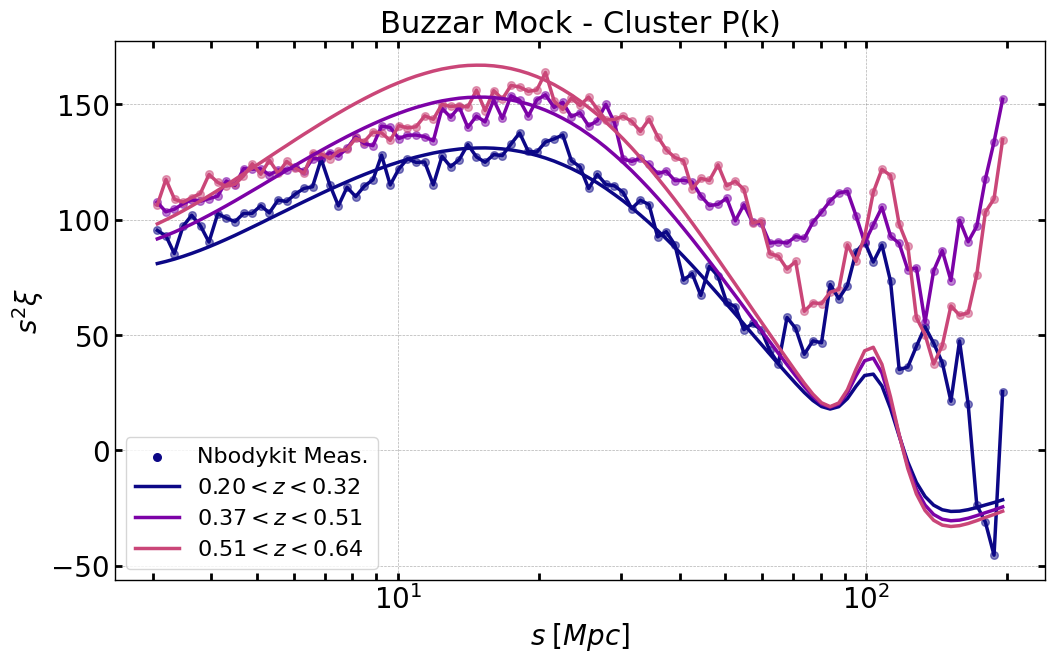

In [113]:
# plt.loglog()
plt.xscale('log')
for i in range(3):
    s, xi = unpack(crfs[i])
    plt.scatter(s, s*s*xi, color=colors[i], alpha=0.5, s=30)
    plt.plot(s, s*s*xi, '-', color=colors[i])

plt.scatter([0],[0], color=colors[0], s=30, label='Nbodykit Meas.')
bias = 2.15*((1+zmeans)/(1+0.25))**(1.2)
for i in range(3):
    xi = bias[i]**2*xi_nonlin[i]
    #plt.scatter(s, s*s*xi, color=colors[i], alpha=0.5, s=30)
    plt.plot(s, s*s*xi, '-', color=colors[i], label=zlabel[i])

plt.legend(loc=0)
plt.xlabel(kwargs['r'])
plt.ylabel(kwargs['xi'])
plt.title('Buzzar Mock - Cluster P(k)')

In [204]:
!ls /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi*

/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z0_k0
/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z0_k0.npz
/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z0_k1.npz
/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z0_k2.npz
/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z0_k3.npz
/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z0_k4.npz
/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z0_k5.npz
/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z0_k6.npz
/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z0_k7.npz
/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z0_k8.npz
/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z0

In [205]:
fname = '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z1_k%i'

kcrfs = []
for i in range(10):
    kcrfs.append(SurveyData2PCF.load(fname%i))

Text(0.5, 1.0, 'Jackknife')

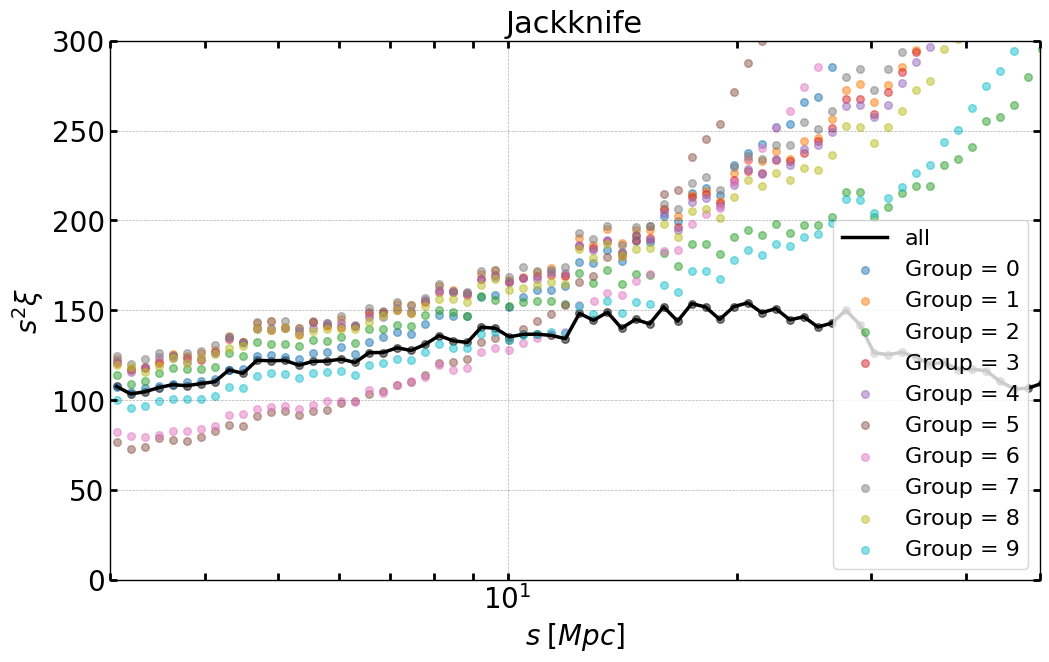

In [206]:
# plt.loglog()
plt.xscale('log')
i=1
s, xi = unpack(crfs[i])
plt.scatter(s, s*s*xi, color='k', alpha=0.5, s=30)
plt.plot(s, s*s*xi, '-', color='k', label='all')

for i in range(10):
    s, xi = unpack(kcrfs[i])
    plt.scatter(s, s*s*xi, alpha=0.5, s=30, label='Group = %i'%i)
    #plt.plot(s, s*s*xi, '-')

# plt.scatter([0],[0], color=colors[0], s=30, label='Nbodykit Meas.')
# bias = 2.15*((1+zmeans)/(1+0.25))**(1.2)
# for i in range(3):
#     xi = bias[i]**2*xi_nonlin[i]
#     #plt.scatter(s, s*s*xi, color=colors[i], alpha=0.5, s=30)
#     plt.plot(s, s*s*xi, '-', color=colors[i], label=zlabel[i])
plt.xlim(3., 50)
plt.ylim(0., 300)
plt.legend(loc=0)
plt.xlabel(kwargs['r'])
plt.ylabel(kwargs['xi'])
plt.title('Jackknife')

## Power Spectrum

In [150]:
!ls -lth /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/*.json

-rw-rw---- 1 jesteves des 92K Nov 25 23:16 /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/power_z2_all.json
-rw-rw---- 1 jesteves des 93K Nov 25 23:13 /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/power_z1_all.json
-rw-rw---- 1 jesteves des 93K Nov 25 23:11 /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/power_z0_all.json


In [151]:
fname = '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/power_z%i_all.json'
powers = []
for i in range(3):
    powers.append(ConvolvedFFTPower.load(fname%i))


In [152]:
from scipy.ndimage import uniform_filter1d

kvec = np.logspace(-3, np.log10(5.), 50)

def roll_average(self, k_break=0.22, Nl=20, Nu=10, kmin=0.01, kmax=2.0):
    power = self.poles.sel(k=slice(kmin, kmax),method='nearest')
    P = power['power_0'].real - power.attrs['shotnoise']
    isnan = np.isnan(np.log(P))
    k, pk = power['k'][~isnan], P[~isnan]
    log_k, log_pk = np.log(k), np.log(pk)

    # rolling average
    y = uniform_filter1d(pk, size=int(k.size/Nl)+1)
    y2 = uniform_filter1d(pk, size=int(k.size/Nu)+1)
    ix = np.where(k>0.22)[0]
    y[ix] = y2[ix]
    return k, pk, y


/tmp/ipykernel_134949/1218005063.py:8: RuntimeWarning: invalid value encountered in log
  isnan = np.isnan(np.log(P))


Text(0.5, 1.0, 'Buzzard Mock - Cluster P(k)')

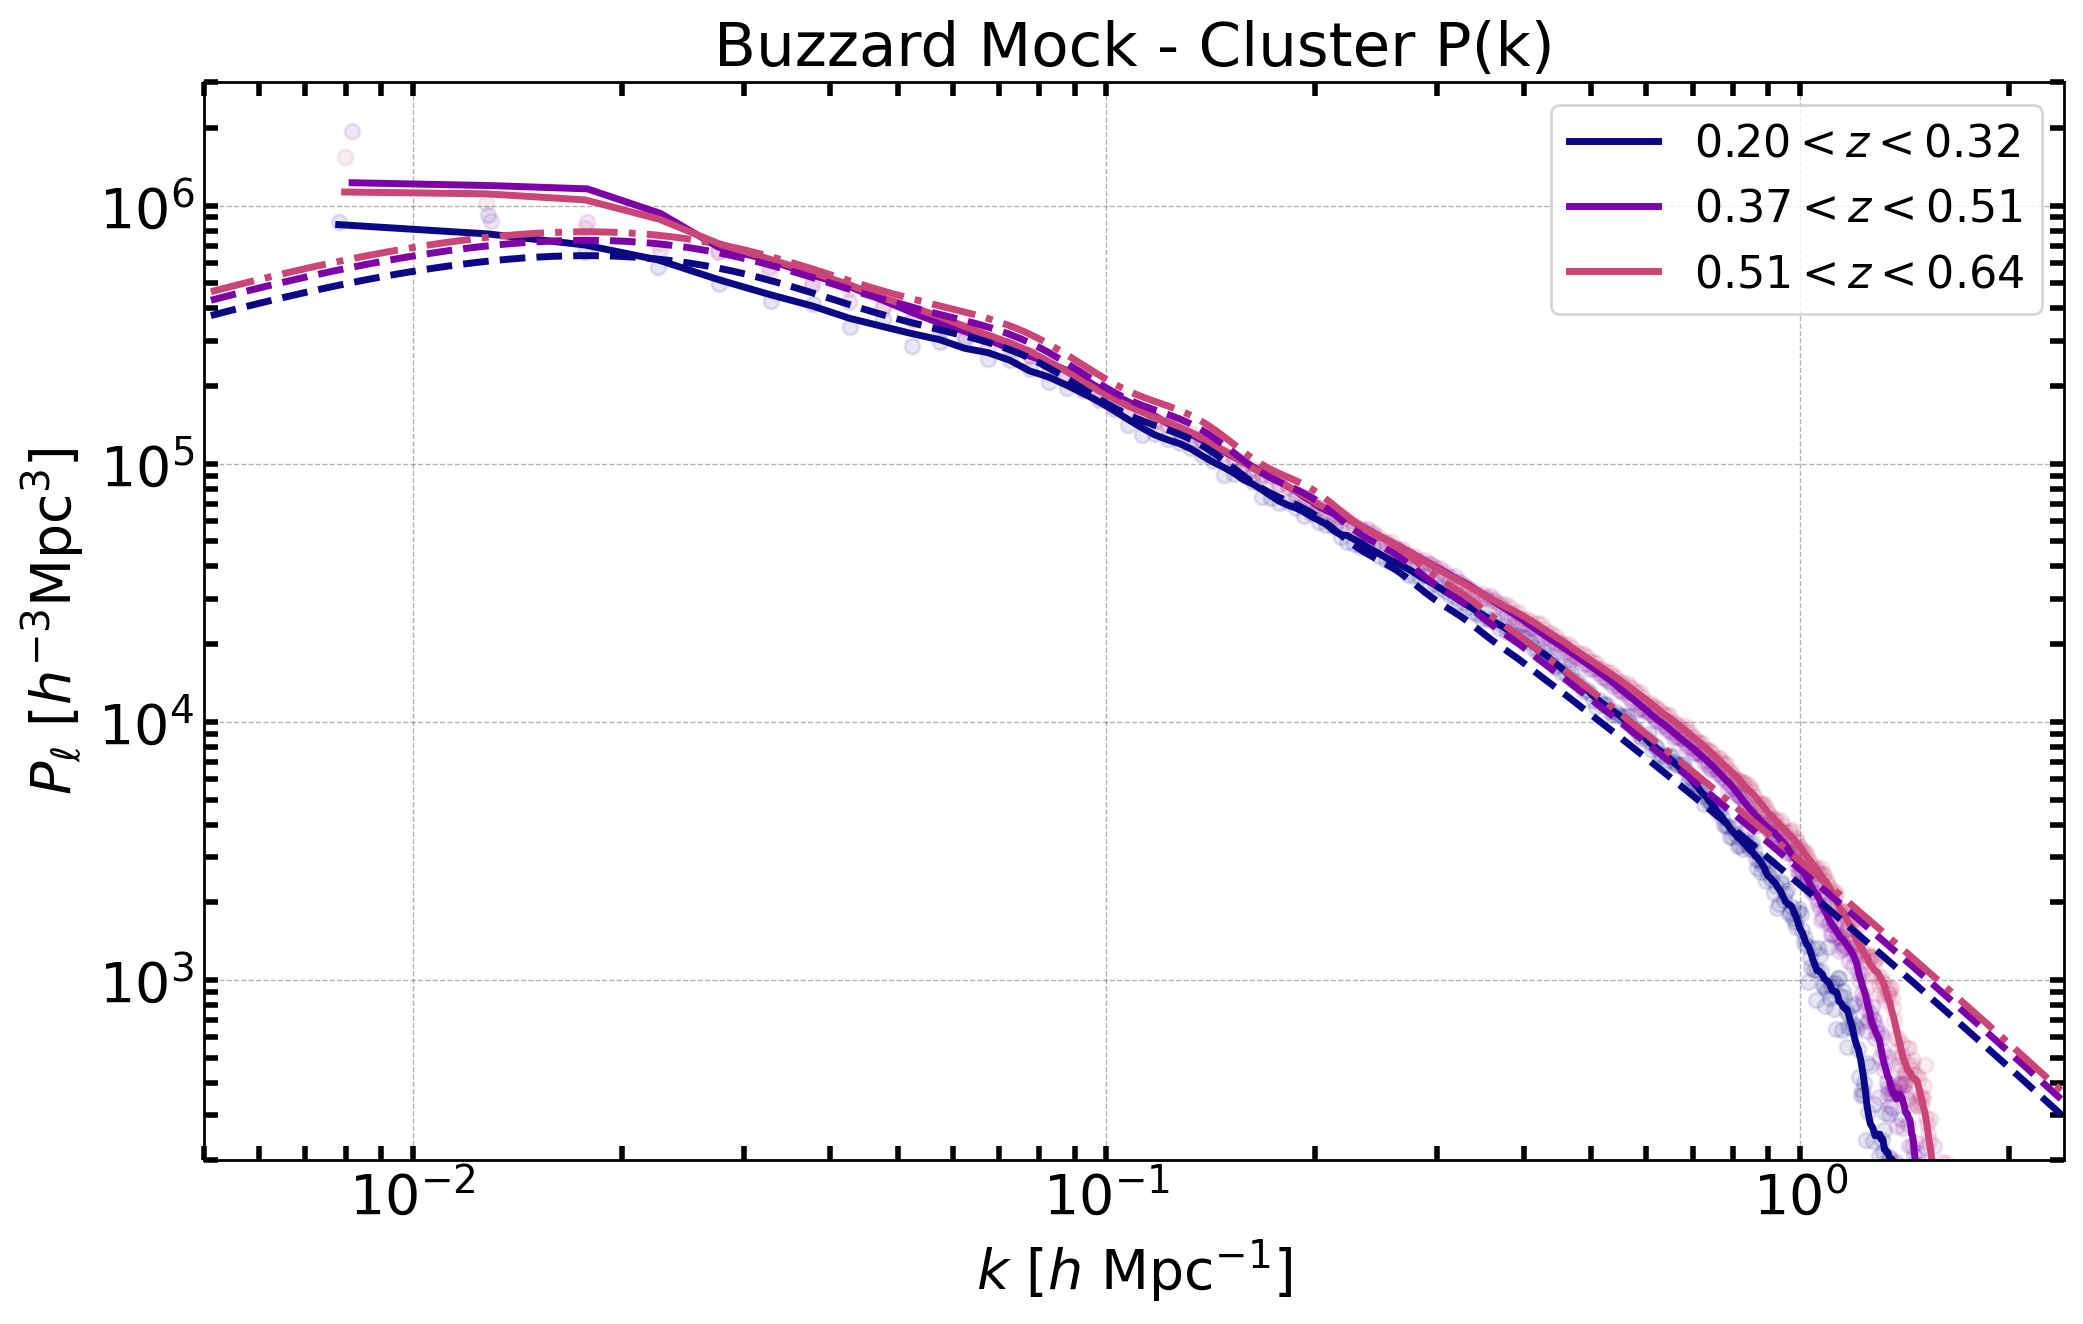

In [153]:
# plt.loglog()
plt.xscale('log')
avg_pks = []
for i in range(3):
    k, pk, pk_avg = roll_average(powers[i], k_break=0.01, Nl=60, Nu=20)
    plt.scatter(k, pk, color=colors[i], alpha=0.1, s=30)
    plt.plot(k, pk_avg, '-', color=colors[i], label=zlabel[i])
    avg_pks.append([k, pk])

# b=6.7
bias = 6.*((1+zmeans)/(1+0.25))**(1.2)
for i, (redshift, line) in enumerate(zip(list(zmeans),['--','--','-.'])):
    #plt.loglog(kh_lin, b**2*pk_lin[i,:], color=colors[i], ls = line)
    plt.loglog(kh_lin, bias[i]**2*pk_lin[i,:], color=colors[i], ls = line)

plt.legend(loc=0)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P_\ell$ [$h^{-3} \mathrm{Mpc}^3$]")
plt.xlim(0.01/2., 2.4)
plt.ylim(2e2, 3e6)
plt.title('Buzzard Mock - Cluster P(k)')